# PySINDy Package Feature Overview

This notebook provides a simple overview of the basic functionality of the PySINDy software package. In addition to demonstrating the basic usage for fitting a SINDy model, we demonstrate several means of customizing the SINDy fitting procedure. These include different forms of input data, different optimization methods, different differentiation methods, and custom feature libraries.

In [1]:
import numpy as np
from scipy.integrate import odeint
from sklearn.model_selection import KFold, GridSearchCV

from pysindy import SINDy
from pysindy.differentiation import FiniteDifference, SmoothedFiniteDifference
from pysindy.optimizers import STLSQ, SR3, LASSO, ElasticNet
from pysindy.feature_library import PolynomialLibrary, FourierLibrary, CustomLibrary, IdentityLibrary

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Basic usage

In [2]:
lorenz = lambda z,t : [10*(z[1] - z[0]), z[0]*(28 - z[2]) - z[1], z[0]*z[1] - 8/3*z[2]]

Train the model.

In [3]:
dt = .002

t_train = np.arange(0,10,dt)
x0_train = [-8,8,27]
x_train = odeint(lorenz, x0_train, t_train)

In [4]:
model = SINDy()
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


Assess results on a test trajectory.

In [5]:
t_test = np.arange(0,15,dt)
x0_test = np.array([8,7,15])
x_test = odeint(lorenz, x0_test, t_test)
x_test_sim = model.simulate(x0_test,t_test)

x_dot_test_computed = model.differentiate(x_test, t=dt)
x_dot_test_predicted = model.predict(x_test)

print('Model score: %f' % model.score(x_test, t=dt))

Model score: 1.000000


Plot the predicted derivatives.

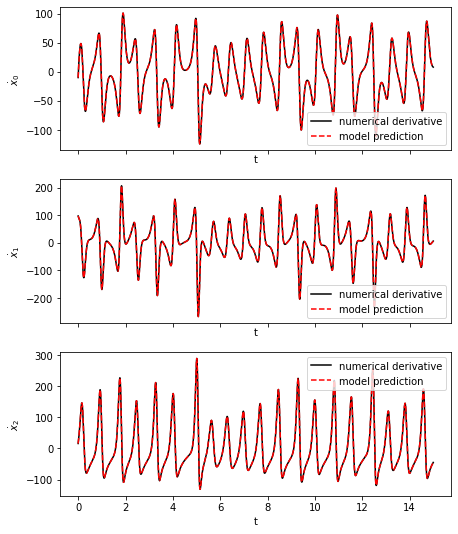

In [6]:
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7,9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:,i], 'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:,i], 'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))

Plot the model simulations.

[Text(0.5, 0, '$x_2$'),
 Text(0.5, 0, '$x_1$'),
 Text(0.5, 0, '$x_0$'),
 Text(0.5, 0.92, 'model simulation')]

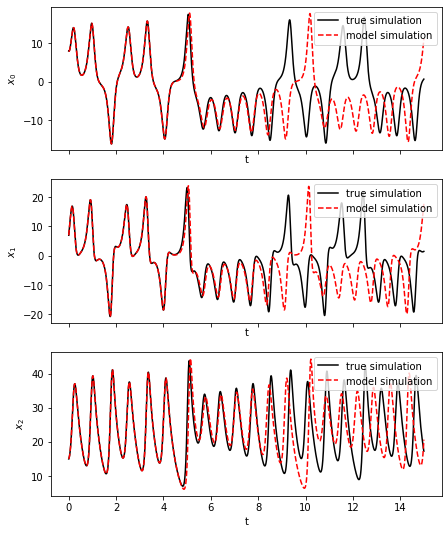

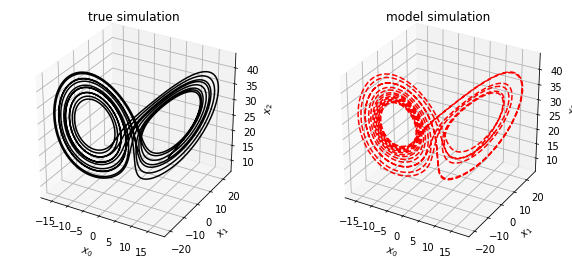

In [7]:
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7,9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:,i], 'k', label='true simulation')
    axs[i].plot(t_test, x_test_sim[:,i], 'r--', label='model simulation')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))
    
fig = plt.figure(figsize=(10,4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:,0],x_test[:,1],x_test[:,2], 'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$', zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:,0],x_test_sim[:,1],x_test_sim[:,2], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$', zlabel='$x_2$', title='model simulation')

# Different forms of input data

## Single trajectory, pass in collection times

In [8]:
model = SINDy()
model.fit(x_train, t=t_train)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## Single trajectory, pass in pre-computed derivatives

In [9]:
x_dot_true = np.zeros(x_train.shape)
for i in range(t_train.size):
    x_dot_true[i] = lorenz(x_train[i], t_train[i])
    
model = SINDy()
model.fit(x_train, t=t_train, x_dot=x_dot_true)
model.print()

x0' = -10.000 x0 + 10.000 x1
x1' = 28.000 x0 + -1.000 x1 + -1.000 x0 x2
x2' = -2.667 x2 + 1.000 x0 x1


## Multiple trajectories

In [10]:
n_trajectories = 20
x0s = np.array([36,48,41])*(np.random.rand(n_trajectories, 3)-.5) + np.array([0,0,25])
x_train_multi = []
for i in range(n_trajectories):
    x_train_multi.append(odeint(lorenz, x0s[i], t_train))
    
model = SINDy()
model.fit(x_train_multi, t=dt, multiple_trajectories=True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.993 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## Multiple trajectories, different lengths of time

In [11]:
n_trajectories = 20
x0s = np.array([36,48,41])*(np.random.rand(n_trajectories, 3)-.5) + np.array([0,0,25])
x_train_multi = []
t_train_multi = []
for i in range(n_trajectories):
    n_samples = np.random.randint(500,1500)
    t = np.arange(0,n_samples*dt,dt)
    x_train_multi.append(odeint(lorenz, x0s[i], t))
    t_train_multi.append(t)
    
model = SINDy()
model.fit(x_train_multi, t=t_train_multi, multiple_trajectories=True)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.993 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## Discrete time dynamical system (map)

In [12]:
n_steps = 1000
f = lambda x : 3.6*x*(1-x)
eps = 0.001
x_train_map = np.zeros((n_steps))
x_train_map[0] = 0.5
for i in range(1,n_steps):
    x_train_map[i] = f(x_train_map[i-1]) + eps*np.random.randn()
    
model = SINDy(discrete_time=True)
model.fit(x_train_map)
model.print()

x0[k+1] = 3.600 x0[k] + -3.600 x0[k]^2


# Customize the optimization method

## STLSQ - change parameters

In [13]:
stlsq_optimizer = STLSQ(threshold=.01, alpha=.5)

model = SINDy(optimizer=stlsq_optimizer)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.990 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## SR3

In [14]:
sr3_optimizer = SR3(threshold=0.1, nu=1)

model = SINDy(optimizer=sr3_optimizer)
model.fit(x_train, t=dt)
model.print()

x0' = -10.005 x0 + 10.003 x1
x1' = 27.991 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 0.999 x0 x1


## LASSO

In [15]:
lasso_optimizer = LASSO(alpha=100)

model = SINDy(optimizer=lasso_optimizer)
model.fit(x_train, t=dt)
model.print()

x0' = -0.298 x0 x2 + 0.329 x1 x2 + -0.002 x2^2
x1' = 1.864 x1 + 0.003 x0 x1 + -0.320 x0 x2 + 0.132 x1 x2 + 0.009 x2^2
x2' = 0.601 x0^2 + 0.581 x0 x1 + -0.004 x1 x2 + -0.112 x2^2


# Customize differentiation

## Pass in pre-computed derivatives

In [16]:
x_dot_precomputed = FiniteDifference()._differentiate(x_train, t_train)
    
model = SINDy()
model.fit(x_train, t=t_train, x_dot=x_dot_precomputed)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## Drop end points from finite difference computation

In [17]:
fd_dropEndpoints = FiniteDifference(drop_endpoints=True)
    
model = SINDy(differentiation_method=fd_dropEndpoints)
model.fit(x_train, t=t_train)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


## Smoothed finite difference

In [18]:
smoothedFD = SmoothedFiniteDifference()
    
model = SINDy(differentiation_method=smoothedFD)
model.fit(x_train, t=t_train)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 27.992 x0 + -0.998 x1 + -1.000 x0 x2
x2' = -2.666 x2 + 1.000 x0 x1


# Customize feature libraries

## Custom feature names

In [19]:
feature_names = ['x','y','z']
model = SINDy(feature_names=feature_names)
model.fit(x_train, t=dt)
model.print()

x' = -9.999 x + 9.999 y
y' = 27.992 x + -0.999 y + -1.000 x z
z' = -2.666 z + 1.000 x y


## Custom left hand side when printing the model

In [20]:
model = SINDy()
model.fit(x_train, t=dt)
model.print(lhs=['dx0/dt','dx1/dt','dx2/dt'])

dx0/dt = -9.999 x0 + 9.999 x1
dx1/dt = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
dx2/dt = -2.666 x2 + 1.000 x0 x1


## Customize polynomial library

In [21]:
poly_library = PolynomialLibrary(include_interaction=False)

model = SINDy(feature_library=poly_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = -72.092 1 + -13.015 x0 + 9.230 x1 + 9.452 x2 + 0.598 x0^2 + -0.289 x1^2 + -0.247 x2^2
x2' = -41.053 1 + 0.624 x0 + -0.558 x1 + 2.866 x2 + 1.001 x0^2 + 0.260 x1^2 + -0.176 x2^2


## Fourier library

In [22]:
fourier_library = FourierLibrary(n_frequencies=3)

model = SINDy(feature_library=fourier_library)
model.fit(x_train, t=dt)
model.print()

x0' = 0.361 sin(1 x0) + 1.015 cos(1 x0) + 6.068 cos(1 x1) + -2.618 sin(1 x2) + 4.012 cos(1 x2) + -0.468 cos(2 x0) + -0.326 sin(2 x1) + -0.883 cos(2 x1) + 0.353 sin(2 x2) + 0.281 cos(2 x2) + 0.436 sin(3 x0) + 0.134 cos(3 x0) + 2.860 sin(3 x1) + 0.780 cos(3 x1) + 2.413 sin(3 x2) + -1.869 cos(3 x2)
x1' = -2.693 sin(1 x0) + -4.096 cos(1 x0) + -0.425 sin(1 x1) + 0.466 cos(1 x1) + -4.697 sin(1 x2) + 7.946 cos(1 x2) + -1.108 sin(2 x0) + -5.631 cos(2 x0) + -1.089 sin(2 x1) + -1.079 cos(2 x1) + 3.288 sin(2 x2) + 1.151 cos(2 x2) + 1.949 sin(3 x0) + 4.829 cos(3 x0) + -0.555 sin(3 x1) + 0.635 cos(3 x1) + 4.257 sin(3 x2) + -3.065 cos(3 x2)
x2' = 5.015 sin(1 x0) + 4.775 cos(1 x0) + 5.615 sin(1 x1) + -3.112 cos(1 x1) + -1.019 sin(1 x2) + 0.345 cos(1 x2) + 2.535 sin(2 x0) + 2.008 cos(2 x0) + -4.250 sin(2 x1) + -13.784 cos(2 x1) + -0.797 sin(2 x2) + 2.578 sin(3 x0) + -0.399 cos(3 x0) + 5.208 sin(3 x1) + -8.286 cos(3 x1) + 0.720 sin(3 x2) + -0.229 cos(3 x2)


## Fully custom library

In [23]:
library_functions = [lambda x : np.exp(x), lambda x : 1./x, lambda x : x, lambda x,y : np.sin(x+y)]
library_function_names = [lambda x : 'exp(' + x + ')', lambda x : '1/' + x, lambda x : x,
                          lambda x,y : 'sin(' + x + ',' + y + ')']
custom_library = CustomLibrary(library_functions=library_functions, function_names=library_function_names)

model = SINDy(feature_library=custom_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = 1.407 1/x0 + -48.091 1/x2 + -12.472 x0 + 9.296 x1 + 0.381 x2 + 0.879 sin(x0,x1) + 1.896 sin(x0,x2) + -0.468 sin(x1,x2)
x2' = 1.094 1/x0 + -7.674 1/x2 + 0.102 x0 + 0.157 x1 + 3.603 sin(x0,x1) + -3.323 sin(x0,x2) + -3.047 sin(x1,x2)


/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.91228e-40): result may not be accurate.
  overwrite_a=True).T
/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.91228e-40): result may not be accurate.
  overwrite_a=True).T
/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.91228e-40): result may not be accurate.
  overwrite_a=True).T


## Fully custom library, default function names

In [24]:
library_functions = [lambda x : np.exp(x), lambda x : 1./x, lambda x : x, lambda x,y : np.sin(x+y)]
custom_library = CustomLibrary(library_functions=library_functions)

model = SINDy(feature_library=custom_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 f2(x0) + 9.999 f2(x1)
x1' = 1.407 f1(x0) + -48.091 f1(x2) + -12.472 f2(x0) + 9.296 f2(x1) + 0.381 f2(x2) + 0.879 f3(x0,x1) + 1.896 f3(x0,x2) + -0.468 f3(x1,x2)
x2' = 1.094 f1(x0) + -7.674 f1(x2) + 0.102 f2(x0) + 0.157 f2(x1) + 3.603 f3(x0,x1) + -3.323 f3(x0,x2) + -3.047 f3(x1,x2)


/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.91228e-40): result may not be accurate.
  overwrite_a=True).T
/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.91228e-40): result may not be accurate.
  overwrite_a=True).T
/Users/kpchamp/opt/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.91228e-40): result may not be accurate.
  overwrite_a=True).T


## Identity library

In [25]:
identity_library = IdentityLibrary()

model = SINDy(feature_library=identity_library)
model.fit(x_train, t=dt)
model.print()

x0' = -9.999 x0 + 9.999 x1
x1' = -12.451 x0 + 9.314 x1 + 0.299 x2
x2' = 0.159 x0 + 0.101 x1
